In [11]:
import skimage.io as io
from IPython.display import Image
import json
import sys
import os
import re
import statistics
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt


In [1]:
"""
Frequency Analysis
"""

COCO_PATH = '../../data/coco/'
COCO_ANNO_PATH = COCO_PATH + 'annotations/'

# load the data from captions
with open(COCO_ANNO_PATH + 'captions_train2014.json') as f:
    coco_captions = json.load(f)
    
    # build the reverse dictionary
    img_captions = {}
    for img_info in coco_captions['images']:
        mid = str(img_info['id'])
        if not mid in img_captions:
            img_captions[mid] = {}
        img_captions[mid]['image'] = img_info
        
    for cap_info in coco_captions['annotations']:
        mid = str(cap_info['image_id'])
        if not 'annotation' in img_captions[mid]:
            img_captions[mid]['annotation'] = []
            img_captions[mid]['captions'] = ''
        img_captions[mid]['annotation'].append(cap_info)
        img_captions[mid]['captions'] += str(cap_info['caption']) + ' '
        

{u'license': 5, u'file_name': u'COCO_train2014_000000008006.jpg', u'coco_url': u'http://mscoco.org/images/8006', u'height': 480, u'width': 640, u'date_captured': u'2013-11-16 14:08:08', u'flickr_url': u'http://farm2.staticflickr.com/1266/729903566_769951485f_z.jpg', u'id': 8006}
http://mscoco.org/images/8006


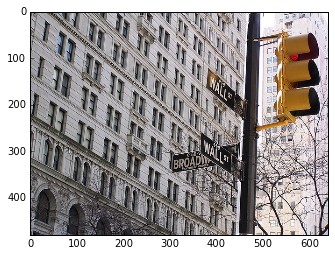

In [24]:
%matplotlib inline


img_id= '8006'
print img_captions['8006']['image']

# print(Image(url=img_captions[img_id]['image']['coco_url']))
I = io.imread(img_captions[img_id]['image']['coco_url'])
plt.figure()
plt.imshow(I)
print img_captions[img_id]['image']['coco_url']

In [3]:
"""
Import Coco Text
"""
CWD = os.getcwd()
COCO_TEXT_PATH = CWD+'/../../coco-text/'
sys.path.insert(0, COCO_TEXT_PATH)
import coco_text as ct

ct = ct.COCO_Text(COCO_PATH + 'COCO_Text.json')

ct.loadAnns(ct.getAnnIds(imgIds='8006'))

loading annotations into memory...
0:00:03.165495
creating index...
index created!


[]

URL:http://mscoco.org/images/77160
Captions is :
A MODIFIED SMART CAR BEARS THE LOGO OF A CATERING COMPANY. A SMALL CAR WITH A CATERING SIGN AND A TENT ON THE BACK. A PERSON SELLING FOOD OUT OF THE BACK OF HIS CATERING CAR. A SMALL CAR THAT HAS A SMALL TENT ERECTED BEHIND IT.  A SMALL CAR WITH ADS ON IT IS PARKED 

Caption Words Set:
set(['', 'THAT', 'BEARS', 'CAR', 'BACK', 'HAS', 'PARKED', 'SMALL', 'WITH', 'HIS', 'COMPANY', 'MODIFIED', '.', 'BEHIND', 'OUT', 'A', 'ADS', 'FOOD', 'IS', 'IT', 'SIGN', 'LOGO', 'THE', 'CATERING', 'SMART', 'AND', 'ON', 'SELLING', 'OF', 'ERECTED', 'PERSON', None, 'TENT'])

Text "CATERING" in caption.
Text "THE" in caption.

Text word set:set([u'INSPIRED', u'512.800.8194', u'CATERING', u'BERLIN', u"MIGUEL'S", u'VERTS.', u'THE', u'CUBANO'])



'Text image coexistence rate: 0.250000'

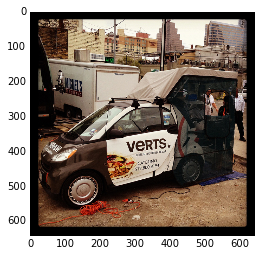

In [28]:
def cal_coexist_rate(img_id):
    I = io.imread(img_captions[img_id]['image']['coco_url'])
    plt.figure()
    plt.imshow(I)
    
    print "URL:%s"% img_captions[img_id]['image']['coco_url']
    cap = img_captions[img_id]['captions'].upper()
    print 'Captions is :\n%s\n'%cap

    cap_words = set(re.split('([,.])*\s', cap))
    print 'Caption Words Set:\n%s\n'%cap_words

    texts = ct.loadAnns(ct.getAnnIds(imgIds=int(img_id)))
    text_words = set()
    coexist_count = 0
    for text in texts:
        if not 'utf8_string' in text:
            continue
        words = text['utf8_string'].upper().split(' ')
        for word in words:
            if word in text_words:
                continue
            else:
                text_words.add(word)

            if word in cap_words:
                print 'Text "%s" in caption.'%word
                coexist_count = coexist_count + 1

    print "\nText word set:%s\n"%text_words
    return coexist_count/float(len(set(text_words))) 

# "\nText image coexistence rate: %f"%cal_coexist_rate('8006')
"Text image coexistence rate: %f"%cal_coexist_rate('77160')
# "Text image coexistence rate: %f"%cal_coexist_rate('296614')


In [78]:
def exclude_small_text(anns, img_id, threshold=0.1):
    """filter out the text annotations with a bounding box smaller than [threshold]*img_area"""
    img_info = img_captions[img_id]['image']
    h,w = img_info['height'], img_info['width']
    return filter(lambda ann: ann['area']>=h*w*threshold, anns)

def exclude_corner_text(anns, img_id, threshold=0.1):
    """filter out the text annotations on sides and corners"""
    img_info = img_captions[img_id]['image']
    h,w = img_info['height'], img_info['width']
    def _judge(ann):
        [x,y,bw,bh]=ann['bbox']
        return  x>=threshold*w and \
                x+bw<=(1-threshold)*w and \
                y+bh<=(1-threshold)*h and \
                y>=threshold*h
    return filter(_judge, anns)
        
def calculate_population_coexist_stat(flags={}):
    """flag: 
    [] -- all captions
    size: n -- excluding small bboxes with size less than n"""
    coexists = []

    for img_id in img_captions.keys():
        cap = img_captions[img_id]['captions'].upper()
        cap_words = set(re.split('([,.])*\s', cap))

        texts = ct.loadAnns(ct.getAnnIds(imgIds=int(img_id)))
        
        #filtering
        if 'size' in flags:
            texts = exclude_small_text(texts, img_id , threshold=flags['size'])
        if 'corner' in flags:
            texts = exclude_corner_text(texts, img_id, threshold=flags['corner'])
        
        if len(texts) == 0:
            continue

        text_words = set()
        coexist_count = 0
        for text in texts:
            if not 'utf8_string' in text:
                continue
            words = text['utf8_string'].upper().split(' ')
            for word in words:
                if word in text_words:
                    continue
                else:
                    text_words.add(word)

                if word in cap_words:
                    coexist_count = coexist_count + 1

        if len(text_words) == 0:
            continue

        img_captions[img_id]['coexistence_data'] = {
            'count'      : coexist_count,
            'text_count' : len(text_words),
            'rate'       : coexist_count/float(len(text_words))
        }

        coexists.append((coexist_count, len(text_words),coexist_count/float(len(text_words)), img_id))
    return coexists

#coexists_large = calculate_population_coexist_stat({'size':0.05})
coexists_center = calculate_population_coexist_stat({'corner':0.25})
#coexists_all = calculate_population_coexist_stat()


In [79]:
def get_stat(data):
    print "\n"
    print "Total:\t%d;\t\tMean:\t\t%f;\tNonezero:\t%d"%(len(data), statistics.mean(data), len(filter(lambda x:x!=0, data)))
    print "Median:\t%f;\tMedian(H):\t%f;\tMedian(L):\t%f;"%(statistics.median(data), statistics.median_high(data), statistics.median_low(data))
    print "Max:\t%f;\tMin:\t\t%f;\tStd:\t\t%f"%(max(data), min(data),statistics.stdev(data))
    print "\n"

dataset = coexists_center
print "Dataset has size:%d" % len(dataset)
for i in [0,1,2]:
    print "Getting the %d data stat:"%i
    get_stat(map(lambda x:x[i], dataset))


Dataset has size:10594
Getting the 0 data stat:


Total:	10594;		Mean:		0.360204;	Nonezero:	2567
Median:	0.000000;	Median(H):	0.000000;	Median(L):	0.000000;
Max:	14.000000;	Min:		0.000000;	Std:		0.772624


Getting the 1 data stat:


Total:	10594;		Mean:		2.752690;	Nonezero:	10594
Median:	2.000000;	Median(H):	2.000000;	Median(L):	2.000000;
Max:	67.000000;	Min:		1.000000;	Std:		3.027331


Getting the 2 data stat:


Total:	10594;		Mean:		0.135520;	Nonezero:	2567
Median:	0.000000;	Median(H):	0.000000;	Median(L):	0.000000;
Max:	1.000000;	Min:		0.000000;	Std:		0.291835




In [ ]:
"""
Demo of the histogram (hist) function with a few features.

In addition to the basic histogram, this demo shows a few optional features:

    * Setting the number of data bins
    * The ``normed`` flag, which normalizes bin heights so that the integral of
      the histogram is 1. The resulting histogram is a probability density.
    * Setting the face color of the bars
    * Setting the opacity (alpha value).

"""
def plot(data,color):
    num_bins = 20
    # the histogram of the data
    n, bins, patches = plt.hist(map(lambda x:x[2], data), num_bins, normed= 1,  facecolor=color, alpha=0.5)

    # add a 'best fit' line
    plt.xlabel('Coexistence Rate')
    plt.ylabel('Frequency')
    plt.title('Coexistence Rate Distribution')

    # Tweak spacing to prevent clipping of ylabel
    plt.subplots_adjust(left=0.15)

plot(coexists_all, 'red')
plot(coexists_center, 'green')
plt.show()

In [8]:
# """
# Frequency chart
# """
# import numpy as np
# import matplotlib.pyplot as plt


# # Pile up the history
# freq = {}
# for i in range(max(map(lambda x:x[2], coexists))):
    

# x1 = np.linspace(0.0, 5.0)
# x2 = np.linspace(0.0, 2.0)

# y1 = np.cos(2 * np.pi * x1) * np.exp(-x1)
# y2 = np.cos(2 * np.pi * x2)

# plt.subplot(2, 1, 1)
# plt.plot(x1, y1, 'yo-')
# plt.title('A tale of 2 subplots')
# plt.ylabel('Damped oscillation')

# plt.subplot(2, 1, 2)
# plt.plot(x2, y2, 'r.-')
# plt.xlabel('time (s)')
# plt.ylabel('Undamped')

# plt.show()


In [9]:
"""
Filter out the max most bunch
"""
# len(img_captions)

high_rates_images = [img_captions[k] for k in img_captions.keys() if ('coexistence_data' in img_captions[k] and img_captions[k]['coexistence_data']['rate'] > 0.9)]
print len(high_rates_images)


1012


In [65]:
print coexists_center[0]
img_captions['376385']['annotation']

(0, 1, 0.0, '376385')


[{u'caption': u'A large crowd is watching a baseball game.',
  u'id': 587066,
  u'image_id': 376385},
 {u'caption': u'Home plate at a professional baseball game, as everyone gets ready.',
  u'id': 588155,
  u'image_id': 376385},
 {u'caption': u'A group of baseball players standing on top of a green field.',
  u'id': 588377,
  u'image_id': 376385},
 {u'caption': u'the ump calling a strike the catcher throwing the ball back to the pitcher and the batter has a strike',
  u'id': 591974,
  u'image_id': 376385},
 {u'caption': u'A baseball game in progress with the batter up to plate.',
  u'id': 592115,
  u'image_id': 376385}]